In [91]:
from datasets import Dataset
from vax_concerns_classifiers import CATEGORIES, DESCRIPTIONS
import pandas as pd
import glob
import os
import ast
from tqdm import tqdm
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

tqdm.pandas()

LOCAL_DIR = os.getcwd()
PARENT_DIR = os.path.join(LOCAL_DIR, '..', '..')
DATA_DIR = os.path.join(PARENT_DIR, 'data', 'common_crawl')

metadata_pattern = "CC-MAIN*/labeled_samples_all/data*.arrow"
metadata_matches = sorted(glob.glob(os.path.join(DATA_DIR, metadata_pattern), recursive=True))
labeled_pattern = "CC-MAIN*/*"
labeled_matches = sorted(glob.glob(os.path.join(LOCAL_DIR, labeled_pattern), recursive=True))

assert len(metadata_matches) == len(labeled_matches)

In [103]:
def plot_time_series(data, title, xlabel, ylabel, resize=False, legend_names=None):
    plt.figure(figsize=(15, 5))

    # Add title and labels
    if title:
        plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel(xlabel, fontsize=16, fontweight='bold')
    plt.ylabel(ylabel, fontsize=16, fontweight='bold')

    # Check if data is a Series or DataFrame
    if isinstance(data, pd.Series):
        plt.plot(data.index, data.values, linestyle='-', linewidth=2)
    else:
        if legend_names is None:
            legend_names = data.columns
        for column, label in zip(data.columns, legend_names):
            plt.plot(data.index, data[column], label=label, linestyle='-', linewidth=2)

    # Show legend if applicable
    if legend_names:
        plt.legend(fontsize=14)

    # Set y-axis limits
    plt.ylim(bottom=0)
    if not resize:
        plt.ylim(0, 1)

    # Format x-axis for yearly ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set x-axis limits
    plt.xlim(data.index.min(), data.index.max())
    ax.tick_params(axis='both', which='major', labelsize=14, width=2)

    plt.show()

def plot_all_time_series(df, x_col, title, y_axis_label, resize=False):
    fig, axes = plt.subplots(len(CATEGORIES), 1, figsize=(15, 3 * len(CATEGORIES)), sharex=False, sharey=False)
    
    for i, ax in enumerate(axes):
        ax.plot(df[x_col], df[CATEGORIES[i]], linestyle='-')
        ax.set_title(f"{title} - {DESCRIPTIONS[i]['cat']}. {DESCRIPTIONS[i]['name']}", fontsize=12)
        ax.set_ylabel(y_axis_label, fontsize=10)
        ax.set_xlabel('Date', fontsize=10)
        if not resize:
            ax.set_ylim(0, 1)
        ax.grid(True)
        
        # Format x-axis for yearly ticks
        ax.xaxis.set_major_locator(mdates.YearLocator(1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.tight_layout()
    plt.show()

In [ ]:
full_df_list = []

for metadata_path, labeled_path in tqdm(zip(metadata_matches, labeled_matches), total=len(metadata_matches)):

# metadata_path = metadata_matches[0]
# labeled_path = labeled_matches[0]

    # Load metadata and filter
    metadata = Dataset.from_file(metadata_path)
    metadata = metadata.filter(lambda row: row['languages'] and row['languages']['languages'] and row['languages']['languages'][0]['code'] == 'en')
    metadata = metadata.to_pandas()

    # Convert metadata to Dask DataFrame
    metadata = dd.from_pandas(metadata[['record_id', 'timestamp']], npartitions=10)

    # Read labeled data using Dask
    df = dd.read_csv(labeled_path).sample(frac=0.0001)

    # convert annotations to individual columns
    df['bert_ann'] = df['bert_ann'].map_partitions(lambda x: x.apply(ast.literal_eval), meta=('bert_ann', 'object'))
    labels = df['bert_ann'].map_partitions(lambda x: x.apply(pd.Series), meta=pd.DataFrame([{cat: 0 for cat in CATEGORIES}]))
    df = dd.concat([df, labels], axis=1)
    df = df.drop(columns=['bert_ann', 'text', 'index'])

    # merge with metadata to get timestamps
    df = df.groupby("record_id").max()
    df = df.merge(metadata, on='record_id', how='inner')
    df['timestamp'] = df['timestamp'].map_partitions(
        lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ', errors='coerce').dt.tz_localize(None),
        meta=('string', 'datetime64[ns]')
    )
    df['time_bin'] = df['published_time'].map_partitions(
        lambda x: pd.to_datetime(x.dt.to_period('M').dt.to_timestamp()), 
        meta=('time_bin', 'datetime64[ns]')
    )

    full_df_list.append(df)

    del df
    del metadata

 15%|█▍        | 9/61 [00:10<01:05,  1.26s/it]

Filter:   0%|          | 0/20009 [00:00<?, ? examples/s]

 16%|█▋        | 10/61 [00:12<01:14,  1.46s/it]

Filter:   0%|          | 0/20001 [00:00<?, ? examples/s]

 18%|█▊        | 11/61 [00:15<01:27,  1.74s/it]

Filter:   0%|          | 0/20001 [00:00<?, ? examples/s]

 20%|█▉        | 12/61 [00:17<01:36,  1.97s/it]

Filter:   0%|          | 0/20001 [00:00<?, ? examples/s]

 21%|██▏       | 13/61 [00:20<01:41,  2.12s/it]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

 23%|██▎       | 14/61 [00:22<01:47,  2.29s/it]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

 25%|██▍       | 15/61 [00:25<01:51,  2.42s/it]

Filter:   0%|          | 0/20016 [00:00<?, ? examples/s]

 26%|██▌       | 16/61 [00:28<01:53,  2.51s/it]

Filter:   0%|          | 0/20016 [00:00<?, ? examples/s]

 28%|██▊       | 17/61 [00:30<01:51,  2.54s/it]

Filter:   0%|          | 0/20016 [00:00<?, ? examples/s]

 30%|██▉       | 18/61 [00:33<01:52,  2.62s/it]

Filter:   0%|          | 0/20015 [00:00<?, ? examples/s]

 31%|███       | 19/61 [00:36<01:49,  2.62s/it]

Filter:   0%|          | 0/20015 [00:00<?, ? examples/s]

 33%|███▎      | 20/61 [00:38<01:46,  2.61s/it]

Filter:   0%|          | 0/14292 [00:00<?, ? examples/s]

 34%|███▍      | 21/61 [00:40<01:36,  2.42s/it]

Filter:   0%|          | 0/14291 [00:00<?, ? examples/s]

 36%|███▌      | 22/61 [00:43<01:34,  2.41s/it]

Filter:   0%|          | 0/14291 [00:00<?, ? examples/s]

 38%|███▊      | 23/61 [00:45<01:27,  2.31s/it]

Filter:   0%|          | 0/14291 [00:00<?, ? examples/s]

 39%|███▉      | 24/61 [00:47<01:25,  2.30s/it]

Filter:   0%|          | 0/14291 [00:00<?, ? examples/s]

 41%|████      | 25/61 [00:49<01:22,  2.29s/it]

Filter:   0%|          | 0/14291 [00:00<?, ? examples/s]

 43%|████▎     | 26/61 [00:52<01:19,  2.27s/it]

Filter:   0%|          | 0/14291 [00:00<?, ? examples/s]

 44%|████▍     | 27/61 [00:54<01:16,  2.25s/it]

Filter:   0%|          | 0/16676 [00:00<?, ? examples/s]

 46%|████▌     | 28/61 [00:56<01:15,  2.29s/it]

Filter:   0%|          | 0/16675 [00:00<?, ? examples/s]

 48%|████▊     | 29/61 [00:58<01:12,  2.28s/it]

Filter:   0%|          | 0/16675 [00:00<?, ? examples/s]

 49%|████▉     | 30/61 [01:01<01:09,  2.24s/it]

Filter:   0%|          | 0/16675 [00:00<?, ? examples/s]

 51%|█████     | 31/61 [01:03<01:09,  2.31s/it]

Filter:   0%|          | 0/16675 [00:00<?, ? examples/s]

 52%|█████▏    | 32/61 [01:06<01:09,  2.38s/it]

Filter:   0%|          | 0/16675 [00:00<?, ? examples/s]

 54%|█████▍    | 33/61 [01:08<01:04,  2.30s/it]

Filter:   0%|          | 0/20009 [00:00<?, ? examples/s]

 56%|█████▌    | 34/61 [01:10<01:05,  2.41s/it]

Filter:   0%|          | 0/20009 [00:00<?, ? examples/s]

 57%|█████▋    | 35/61 [01:13<01:02,  2.42s/it]

Filter:   0%|          | 0/20008 [00:00<?, ? examples/s]

 59%|█████▉    | 36/61 [01:15<01:01,  2.47s/it]

Filter:   0%|          | 0/20008 [00:00<?, ? examples/s]

 61%|██████    | 37/61 [01:18<00:58,  2.45s/it]

Filter:   0%|          | 0/20008 [00:00<?, ? examples/s]

 62%|██████▏   | 38/61 [01:21<00:58,  2.56s/it]

Filter:   0%|          | 0/16668 [00:00<?, ? examples/s]

 64%|██████▍   | 39/61 [01:23<00:53,  2.45s/it]

Filter:   0%|          | 0/16667 [00:00<?, ? examples/s]

 66%|██████▌   | 40/61 [01:25<00:49,  2.38s/it]

Filter:   0%|          | 0/16667 [00:00<?, ? examples/s]

 67%|██████▋   | 41/61 [01:27<00:48,  2.41s/it]

Filter:   0%|          | 0/16667 [00:00<?, ? examples/s]

 69%|██████▉   | 42/61 [01:30<00:45,  2.41s/it]

Filter:   0%|          | 0/16667 [00:00<?, ? examples/s]

 70%|███████   | 43/61 [01:32<00:41,  2.28s/it]

Filter:   0%|          | 0/16667 [00:00<?, ? examples/s]

 72%|███████▏  | 44/61 [01:34<00:37,  2.20s/it]

Filter:   0%|          | 0/16672 [00:00<?, ? examples/s]

 74%|███████▍  | 45/61 [01:36<00:35,  2.22s/it]

Filter:   0%|          | 0/16672 [00:00<?, ? examples/s]

 75%|███████▌  | 46/61 [01:38<00:33,  2.25s/it]

Filter:   0%|          | 0/16672 [00:00<?, ? examples/s]

 77%|███████▋  | 47/61 [01:40<00:30,  2.18s/it]

Filter:   0%|          | 0/16671 [00:00<?, ? examples/s]

 79%|███████▊  | 48/61 [01:43<00:28,  2.16s/it]

Filter:   0%|          | 0/16671 [00:00<?, ? examples/s]

 80%|████████  | 49/61 [01:45<00:26,  2.17s/it]

Filter:   0%|          | 0/16671 [00:00<?, ? examples/s]

 82%|████████▏ | 50/61 [01:47<00:23,  2.13s/it]

Filter:   0%|          | 0/16670 [00:00<?, ? examples/s]

 84%|████████▎ | 51/61 [01:49<00:21,  2.13s/it]

Filter:   0%|          | 0/16670 [00:00<?, ? examples/s]

 85%|████████▌ | 52/61 [01:51<00:19,  2.18s/it]

Filter:   0%|          | 0/16669 [00:00<?, ? examples/s]

 87%|████████▋ | 53/61 [01:53<00:17,  2.17s/it]

Filter:   0%|          | 0/16669 [00:00<?, ? examples/s]

 89%|████████▊ | 54/61 [01:56<00:15,  2.20s/it]

Filter:   0%|          | 0/16669 [00:00<?, ? examples/s]

 90%|█████████ | 55/61 [01:58<00:13,  2.29s/it]

Filter:   0%|          | 0/16669 [00:00<?, ? examples/s]

 92%|█████████▏| 56/61 [02:00<00:11,  2.26s/it]

Filter:   0%|          | 0/20010 [00:00<?, ? examples/s]

 93%|█████████▎| 57/61 [02:03<00:09,  2.34s/it]

Filter:   0%|          | 0/20010 [00:00<?, ? examples/s]

 95%|█████████▌| 58/61 [02:06<00:07,  2.47s/it]

Filter:   0%|          | 0/20010 [00:00<?, ? examples/s]

 97%|█████████▋| 59/61 [02:08<00:04,  2.49s/it]

Filter:   0%|          | 0/20010 [00:00<?, ? examples/s]

 98%|█████████▊| 60/61 [02:11<00:02,  2.48s/it]

Filter:   0%|          | 0/20010 [00:00<?, ? examples/s]

100%|██████████| 61/61 [02:13<00:00,  2.19s/it]


In [ ]:
# Efficiently concatenate all Dask DataFrames
full_df = dd.concat(full_df_list).compute()

/Users/christopherli/anaconda3/envs/vax_trends/lib/python3.11/site-packages/dask_expr/_expr.py:1471: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return get_meta_library(args[0]).to_datetime(*args, **kwargs)


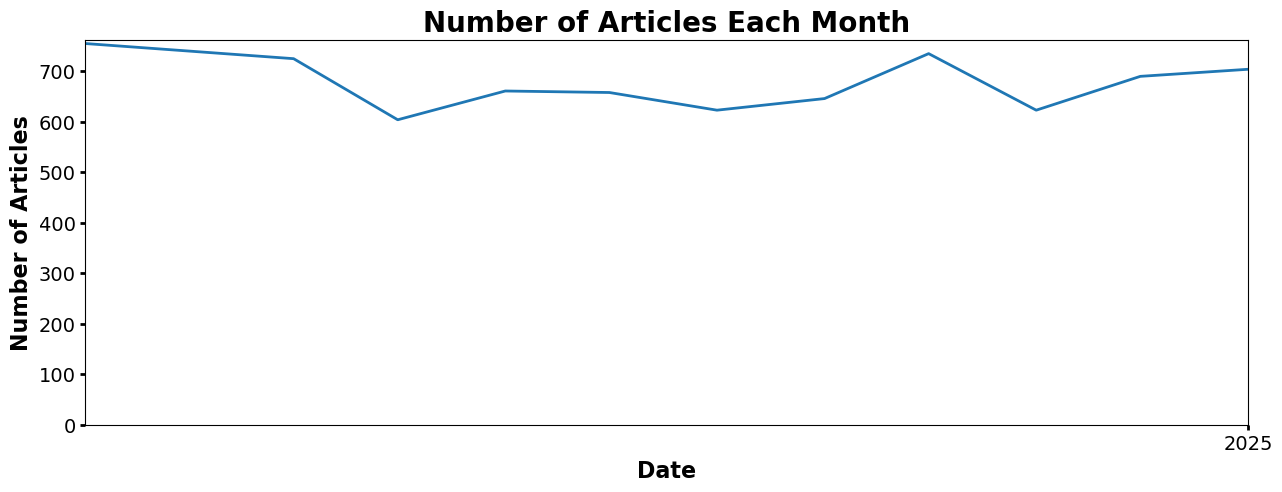

Total number of articles: 7424


In [106]:
# get the number of articles for each month
support = full_df.groupby("time_bin")["record_id"].nunique()
plot_time_series(support, "Number of Articles Each Month", 'Date', 'Number of Articles', resize=True)
print(f"Total number of articles: {support.sum()}")

In [121]:
# get list of unique timestamp days from full_df
unique_days = full_df['timestamp'].dt.date.unique()
# Convert to datetime and sort
unique_days = pd.to_datetime(unique_days)
unique_days = unique_days.sort_values()
unique_days
# len(unique_days)

DatetimeIndex(['2024-02-20', '2024-02-21', '2024-04-12', '2024-05-17',
               '2024-05-18', '2024-06-12', '2024-07-12', '2024-08-02',
               '2024-08-03', '2024-09-07', '2024-10-03', '2024-11-01',
               '2024-11-02', '2024-12-01', '2025-01-12', '2025-01-26'],
              dtype='datetime64[ns]', freq=None)

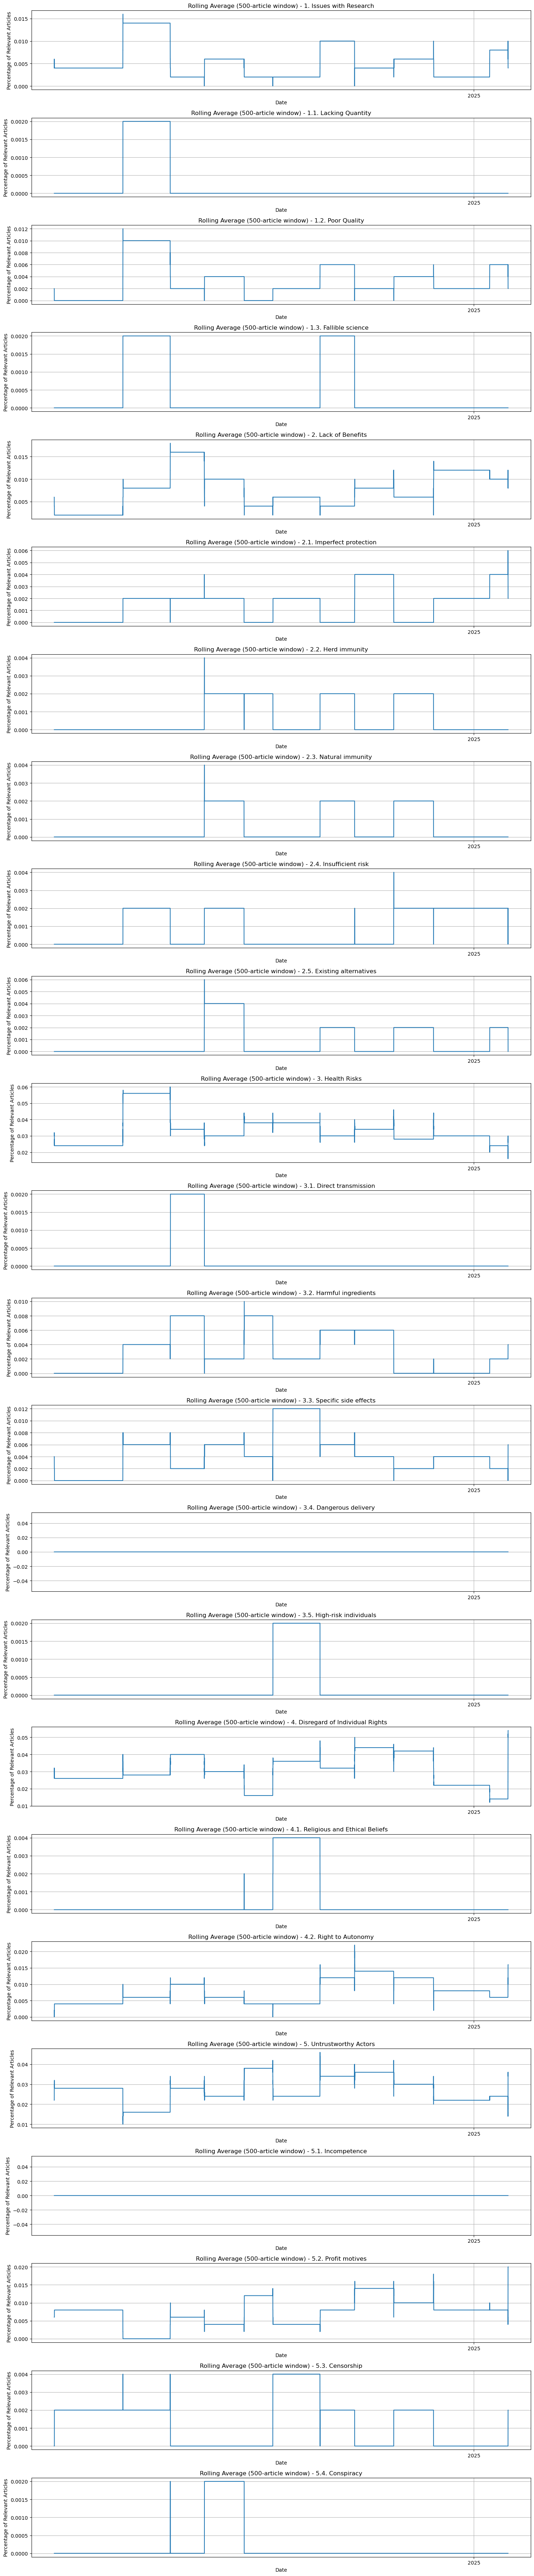

In [117]:
# get rolling average for each concern
rolling_avg = full_df.sort_values('timestamp')

window = 500
numeric_columns = full_df.select_dtypes("number").columns
for col in numeric_columns:
    rolling_avg[col] = (rolling_avg[col]
        .rolling(window=window, min_periods=1)
        .mean()
    )
rolling_avg = rolling_avg[window - 1:]

plot_all_time_series(rolling_avg, 'timestamp', f'Rolling Average ({window}-article window)', 'Percentage of Relevant Articles', resize=True)